# W261 Final Project

#### *Anusha Munjuluri, Arvindh Ganesan, Kim Vignola, Christina Papadimitriou*

### Notebook Set-up

In [1]:
# imports
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# store path to notebook
PWD = !pwd
PWD = PWD[0]

In [3]:
# start Spark Session
from pyspark.sql import SparkSession
app_name = "final_project"
master = "local[*]"
spark = SparkSession\
        .builder\
        .appName(app_name)\
        .master(master)\
        .getOrCreate()
sc = spark.sparkContext

## 1. Question Formulation

## 2. Algorithm Explanation

### Data Loading and Pre-Processing

In [4]:
# take a look at the data
!head -n 1 data/train.txt

0	1	1	5	0	1382	4	15	2	181	1	2		2	68fd1e64	80e26c9b	fb936136	7b4723c4	25c83c98	7e0ccccf	de7995b8	1f89b562	a73ee510	a8cd5504	b2cb9c98	37c9c164	2824a5f6	1adce6ef	8ba8b39a	891b62e7	e5ba7672	f54016b9	21ddcdc9	b1252a9d	07b5194c		3a171ecb	c5c50484	e8b83407	9727dd16


In [5]:
# load the data
fullTrainRDD = sc.textFile('data/train.txt')
testRDD = sc.textFile('data/test.txt')

FIELDS = ['I1','I2','I3','I4','I5','I6','I7','I8','I9','I10','I11','I12','I13',
          'C1','C2','C3','C4','C5','C6','C7','C8','C9','C10','C11','C12','C13','C14',
          'C15','C16','C17','C18','C19','C20','C21','C22','C23','C24','C25','C26','Label']

In [6]:
# number of rows in train/test data
print(f"Number of records in train data: {fullTrainRDD.count()} ...")
print(f"Number of records in test data: {testRDD.count()} ...")

Number of records in train data: 45840617 ...
Number of records in test data: 6042135 ...


In [8]:
# Generate 80/20 (pseudo)random train/test split 
trainRDD, heldOutRDD = fullTrainRDD.randomSplit([0.8,0.2], seed = 1)
print(f"... held out {heldOutRDD.count()} records for evaluation and assigned {trainRDD.count()} for training.")

... held out 9167871 records for evaluation and assigned 36672746 for training.


In [50]:
# helper functions
def parse(line):
    """
    Map line --> tuple of (features, label)
    """
    fields = line.split('\t')
    features,label = fields[1:], fields[0]
    return(features, label)

def edit_data_types(line):
    """
    Map tuple of (features, label) --> tuple of (formated features, label)
    
    * '' is replaced with 'null'
    * numerical fields are converted to integers
    """
    features, label = line[0], line[1]
    formated_features = []
    for i, value in enumerate(features):
        if value == '':
            formated_features.append(np.nan)
        else:
            if i < 13:
                formated_features.append(int(value)) 
            else:
                formated_features.append(value)
    return (formated_features, label)

In [51]:
trainRDDCached = trainRDD.map(parse).map(edit_data_types).cache()

In [52]:
print(trainRDDCached.take(1))

[([1, 1, 5, 0, 1382, 4, 15, 2, 181, 1, 2, nan, 2, '68fd1e64', '80e26c9b', 'fb936136', '7b4723c4', '25c83c98', '7e0ccccf', 'de7995b8', '1f89b562', 'a73ee510', 'a8cd5504', 'b2cb9c98', '37c9c164', '2824a5f6', '1adce6ef', '8ba8b39a', '891b62e7', 'e5ba7672', 'f54016b9', '21ddcdc9', 'b1252a9d', '07b5194c', nan, '3a171ecb', 'c5c50484', 'e8b83407', '9727dd16'], '0')]


In [55]:
sample = np.array(trainRDDCached.map(lambda x: np.append(x[0], [x[1]])).takeSample(False, 1000))
sample_df = pd.DataFrame(np.array(sample), columns = FIELDS)

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,I11,I12,I13,C1,C2,C3,C4,C5,C6,C7
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,34,213,100,49,813,263,101,52,280,6,39,11,54,51,198,771,644,24,7,700
top,nan,1,nan,nan,1,nan,0,0,nan,nan,1,nan,nan,05db9164,38a947a1,nan,c18be181,25c83c98,7e0ccccf,1c86e0eb
freq,461,169,225,214,23,203,190,111,51,461,355,778,214,492,127,36,38,691,366,25


## 3. EDA & Discussion of Challenges

In [107]:
sample_df.iloc[:,0:21].describe(include = "all")

,I1,I2,I3,I4,I5,I6,I7,I8,I9,I10,...,I12,I13,C1,C2,C3,C4,C5,C6,C7,C8
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,...,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,34,213,100,49,813,263,101,52,280,6,...,11,54,51,198,771,644,24,7,700,37
top,nan,1,nan,nan,1,nan,0,0,nan,nan,...,nan,nan,05db9164,38a947a1,nan,c18be181,25c83c98,7e0ccccf,1c86e0eb,0b153874
freq,461,169,225,214,23,203,190,111,51,461,...,778,214,492,127,36,38,691,366,25,604


In [106]:
sample_df.iloc[:,21:39].describe(include = "all")

,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26
count,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000,1000
unique,2,600,579,723,533,18,561,685,9,400,121,4,712,6,12,472,26,340
top,a73ee510,3b08e48b,755e4a50,nan,5978055e,b28479f6,2d0bb053,nan,e5ba7672,e88ffc9d,nan,nan,nan,nan,32c7478e,b34f3128,nan,nan
freq,909,207,39,36,39,375,23,36,469,38,465,465,36,745,460,60,465,465


In [91]:
# Take a subset of the dataframe with only numeric features
sample_numeric = sample_df[FIELDS[0:13]]
columns = ['I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13']
sample_numeric = sample_num.reindex(columns=columns)
sample_numeric[columns] = sample_numeric[columns].astype(np.float)


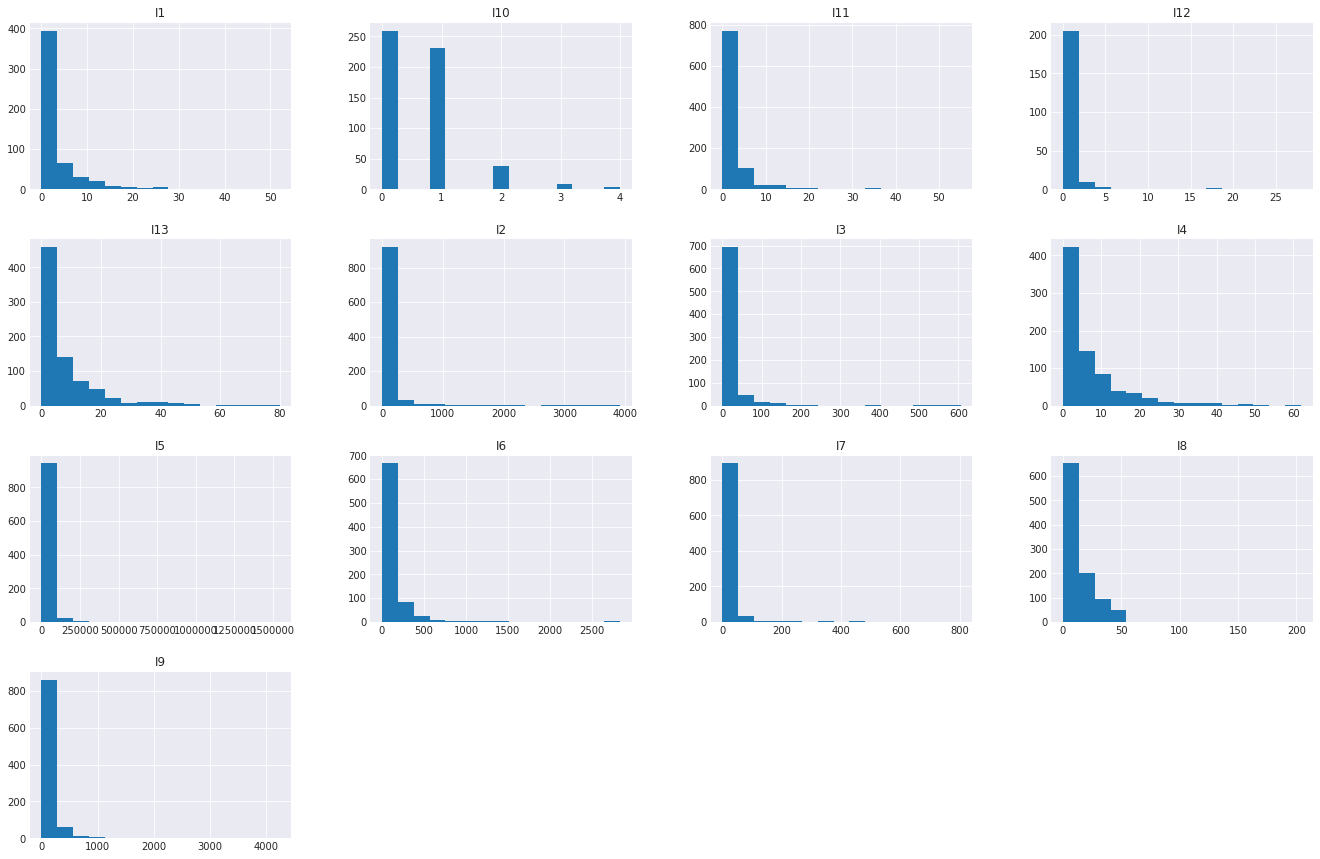

In [101]:
# Take a look at histograms for each feature (RUN THIS CELL AS IS)
sample_numeric.hist(figsize=(23,15), bins=15)
#sample_numeric[FIELDS[:-1]].hist(figsize=(15,15), bins=15)
plt.show()

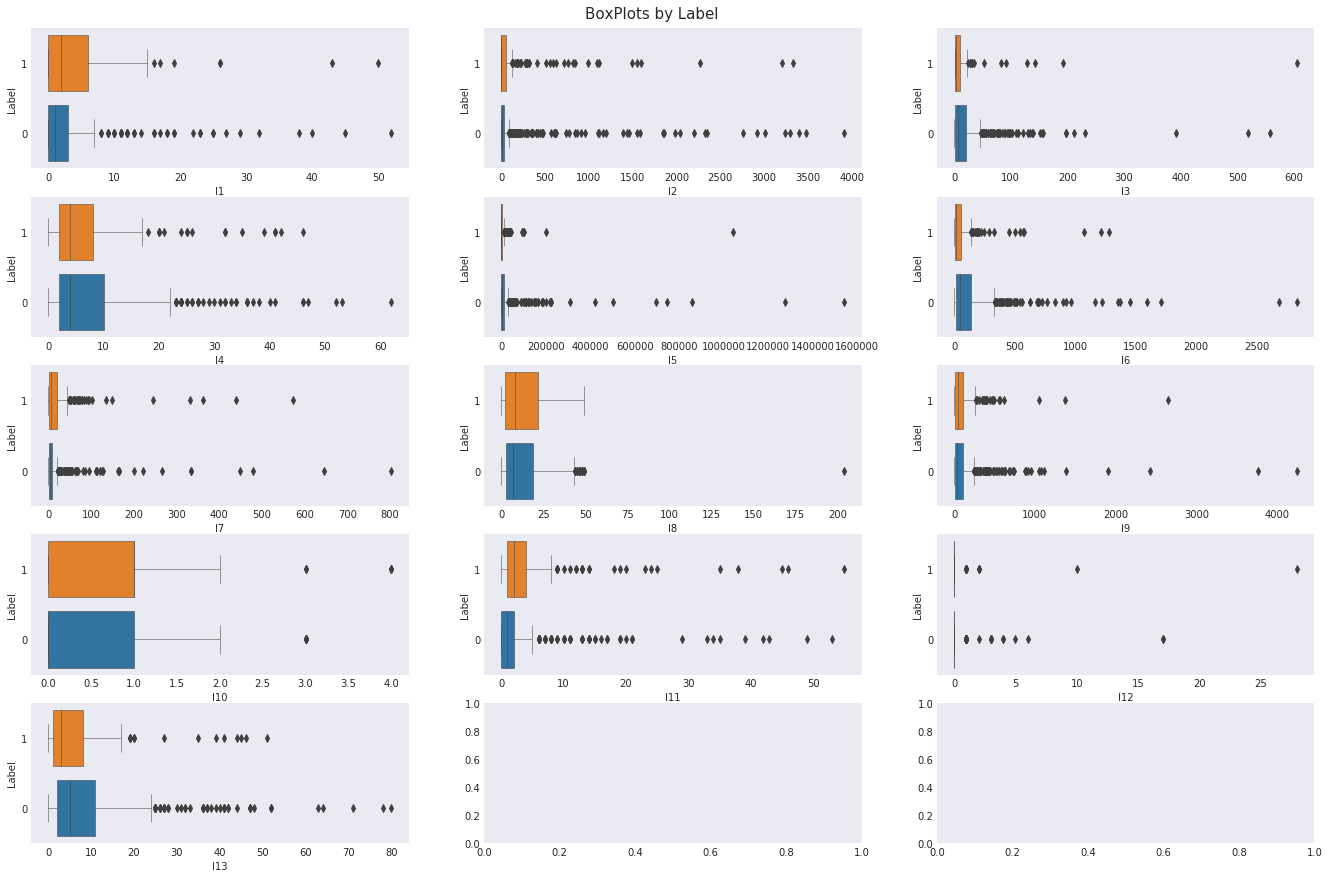

In [100]:
# part b -  plot boxplots of each feature vs. the outcome (RUN THIS CELL AS IS)

fig, ax_grid = plt.subplots(5, 3, figsize=(23,15))
y = sample_df['Label']
for idx, feature in enumerate(FIELDS[0:13]):
    x = sample_num[feature]
    sns.boxplot(x, y, ax=ax_grid[idx//3][idx%3], orient='h', linewidth=.5)
    ax_grid[idx//3][idx%3].invert_yaxis()
fig.suptitle("BoxPlots by Label", fontsize=15, y=0.9)
plt.show()

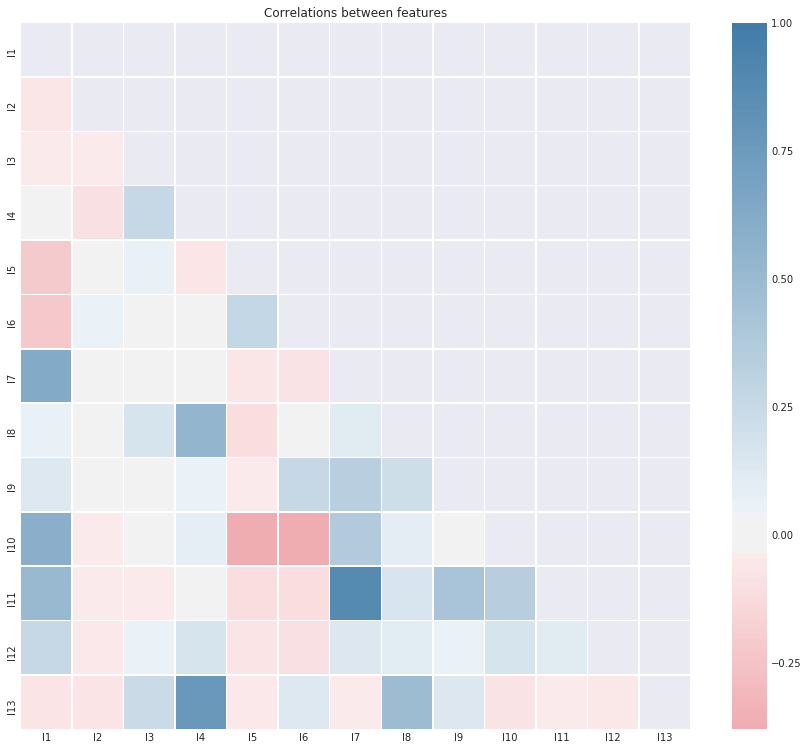

In [104]:
corr = sample_numeric[FIELDS[:13]].corr()
fig, ax = plt.subplots(figsize=(15, 13))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(10, 240, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features")
plt.show()

## 4. Algorithm Implementation

## 5. Application of Course Concepts